# Census Exploratory Data Analysis 
This EDA uses data from the Census' 2015 5-year estimate data, obtained from [Kaggle](https://www.kaggle.com/muonneutrino/new-york-city-census-data?select=census_block_loc.csv)

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import re

from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

---
## Imports
---

In [3]:
census = pd.read_csv('./cleaned_datasets/cleaned_census_data.csv', index_col=0)
census_blocks = pd.read_csv('./cleaned_datasets/cleaned_census_blocks_data.csv', index_col=0)

---
## Census EDA
---

In [4]:
census_blocks.columns

Index(['Latitude', 'Longitude', 'CensusTract', 'County', 'Borough', 'TotalPop',
       'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Citizen', 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr',
       'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
       'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk',
       'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [5]:
def census_block_map(col, colors):
    """
    This function takes a column name from the census_block DataFrame and a colormap string,
    and plots the city using the census block grid with the column data color-blocked per 
    Census Tract 
    """
    # splitting col name with re.findall() as per https://stackoverflow.com/questions/2277352/split-a-string-at-uppercase-letters
    subtitle = " ".join(re.findall('[A-Z][^A-Z]*', col))
    census_blocks.plot(kind='scatter', x='Longitude', y='Latitude', 
                                    c=col, cmap=colors, 
                                    figsize=(18, 14), marker='s', s=14, alpha=1, legend=True)
    plt.ylabel('Latitude', fontsize=24)
    plt.xlabel('Longitude', fontsize=24)
    plt.title(f'Census Tract Blocks: \n{subtitle}', fontsize=32, y=1.02);

---
## *The* City
---

#### Population
To start, the total population shows why NYC is a good candidate for modeling arrest data on, although it’s not uniformly dense, it’s all relatively densely populated 

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


12999

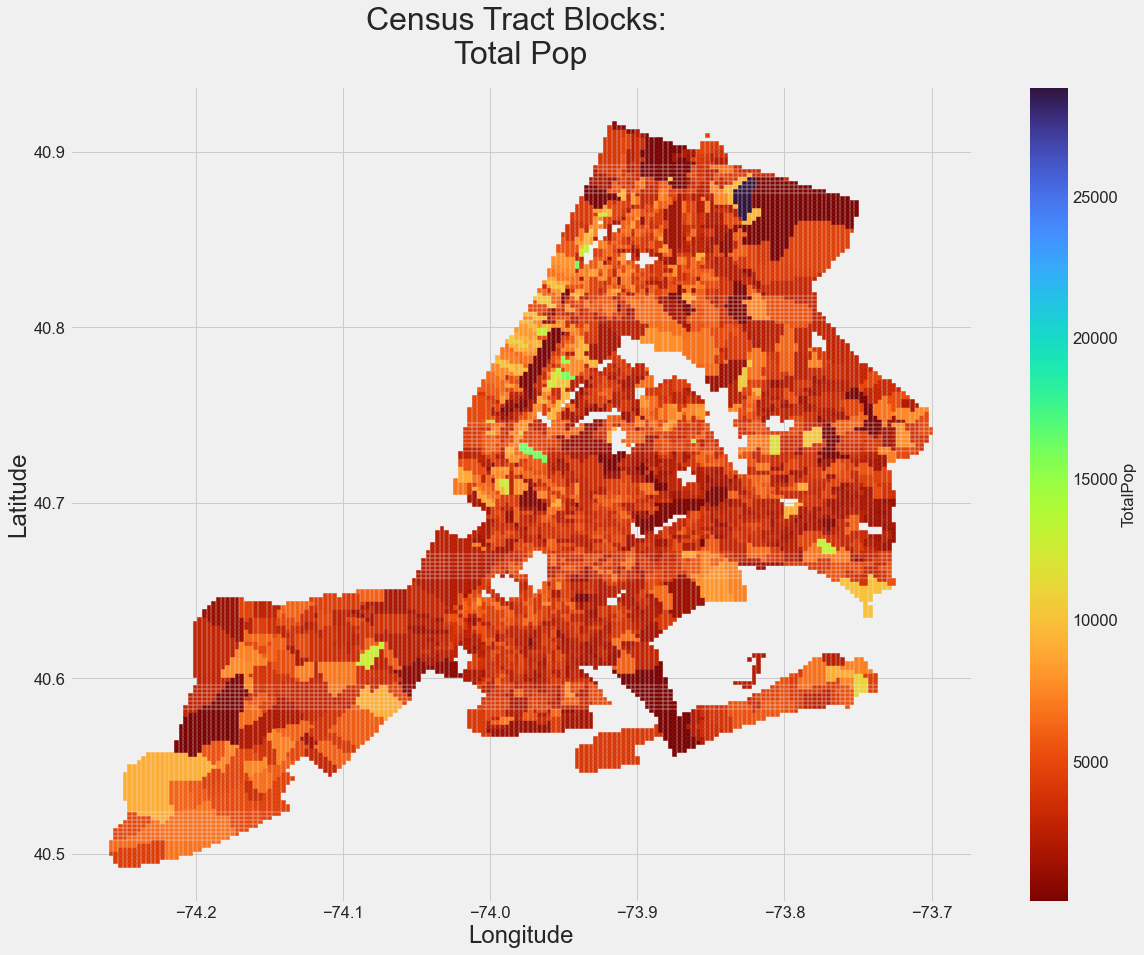

In [29]:
census_block_map('TotalPop', 'turbo_r')
census_blocks.shape[0]

Below is the same plot, but using the consolidated Census Tract points used for the Haversine calculations at the end of the data cleaning notebook. Here, each set of blocks that makes up a Census Tract has had all the Latitudes and Longitudes in that tract averaged to make a single point representing that Tract, reducing processing requirements by almost 5x 

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


2113

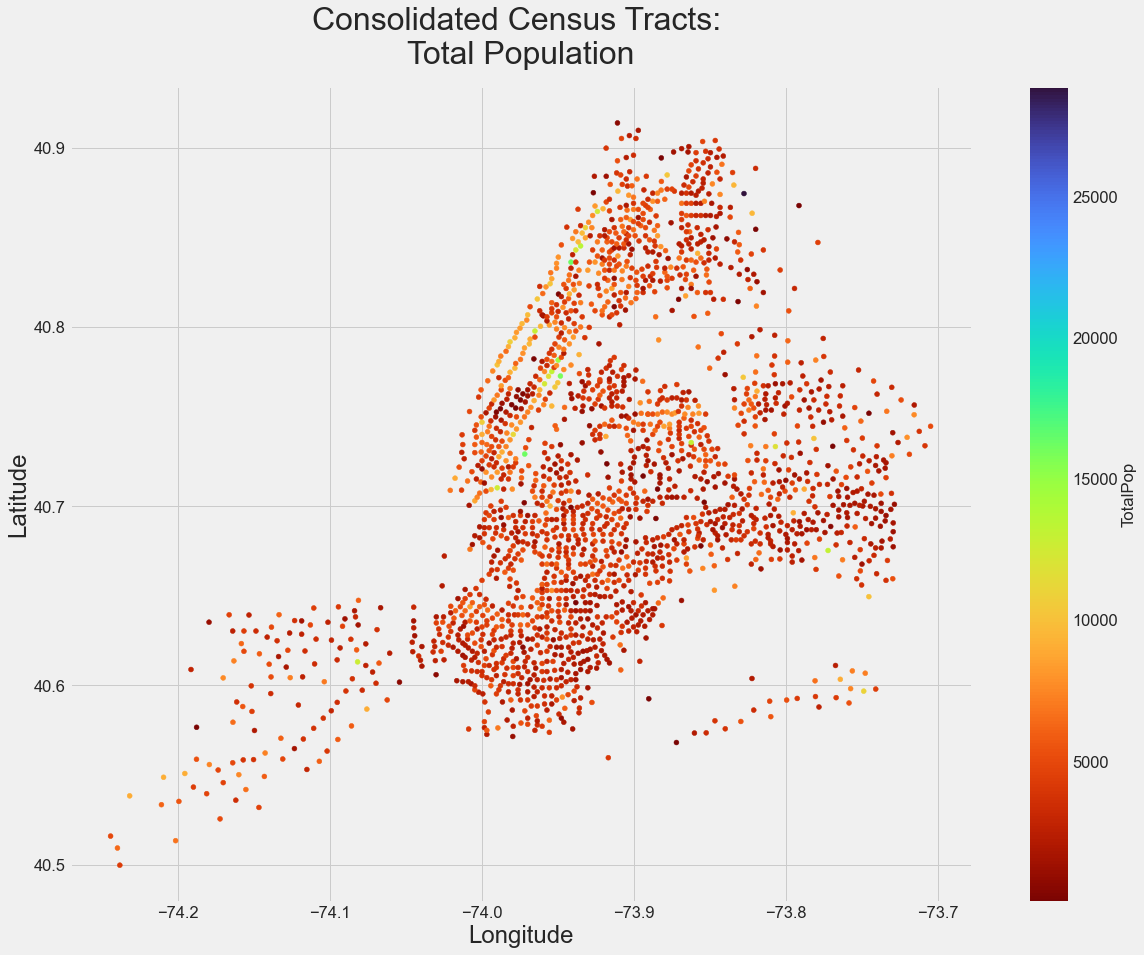

In [28]:
census.plot(kind='scatter', x='Longitude', y='Latitude', 
                                    c='TotalPop', cmap="turbo_r", 
                                    figsize=(18, 14), marker='o', s=24, alpha=1, legend=True)
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.title('Consolidated Census Tracts: \nTotal Population', fontsize=32, y=1.02);
census.shape[0]

---

#### Economic Factors
Income and Income Per Capita are highly concentrated in Manhattan, and that can be seen both in the distribution of Private Sector and Public Sector work, the hotspots of Child Poverty, and Mean Commute Time 

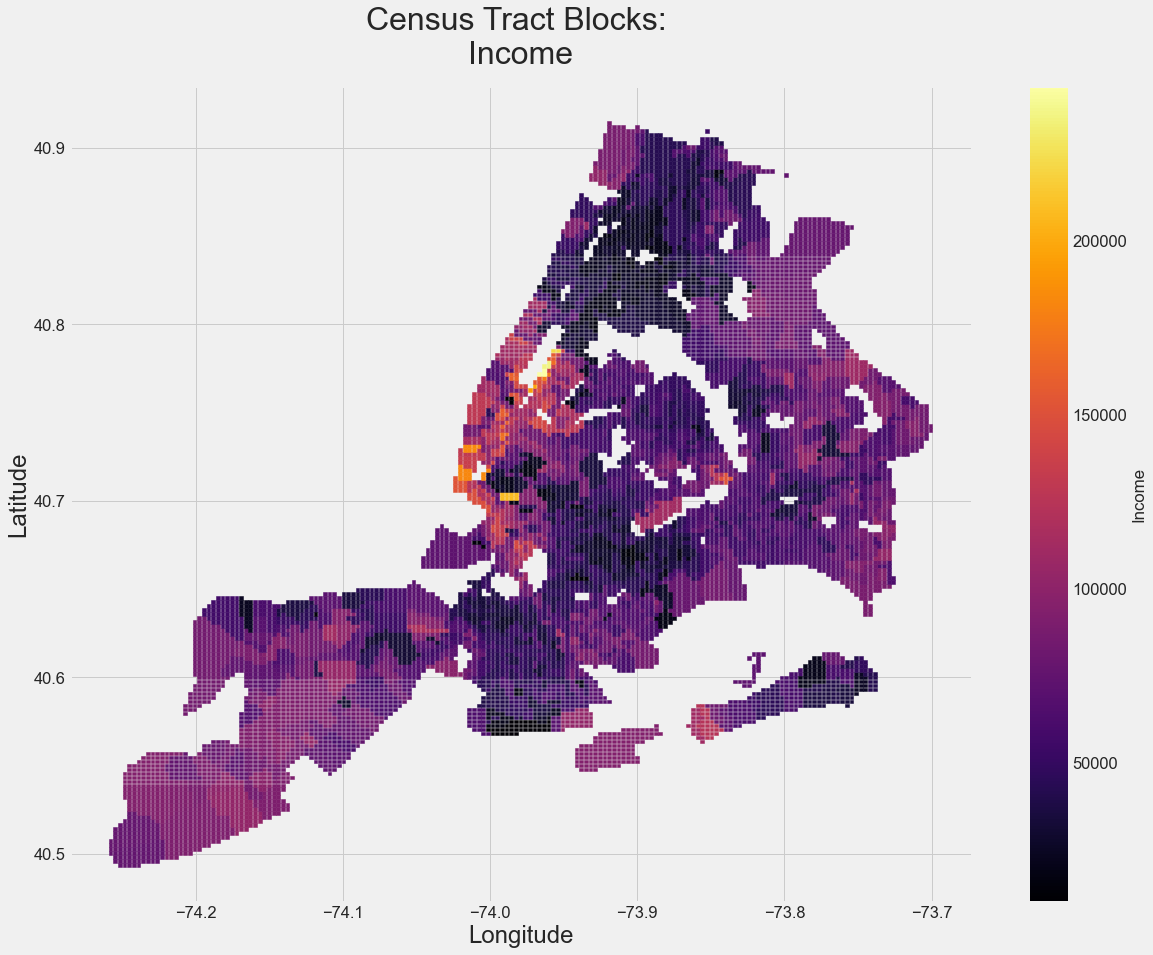

In [8]:
census_block_map('Income', 'inferno')

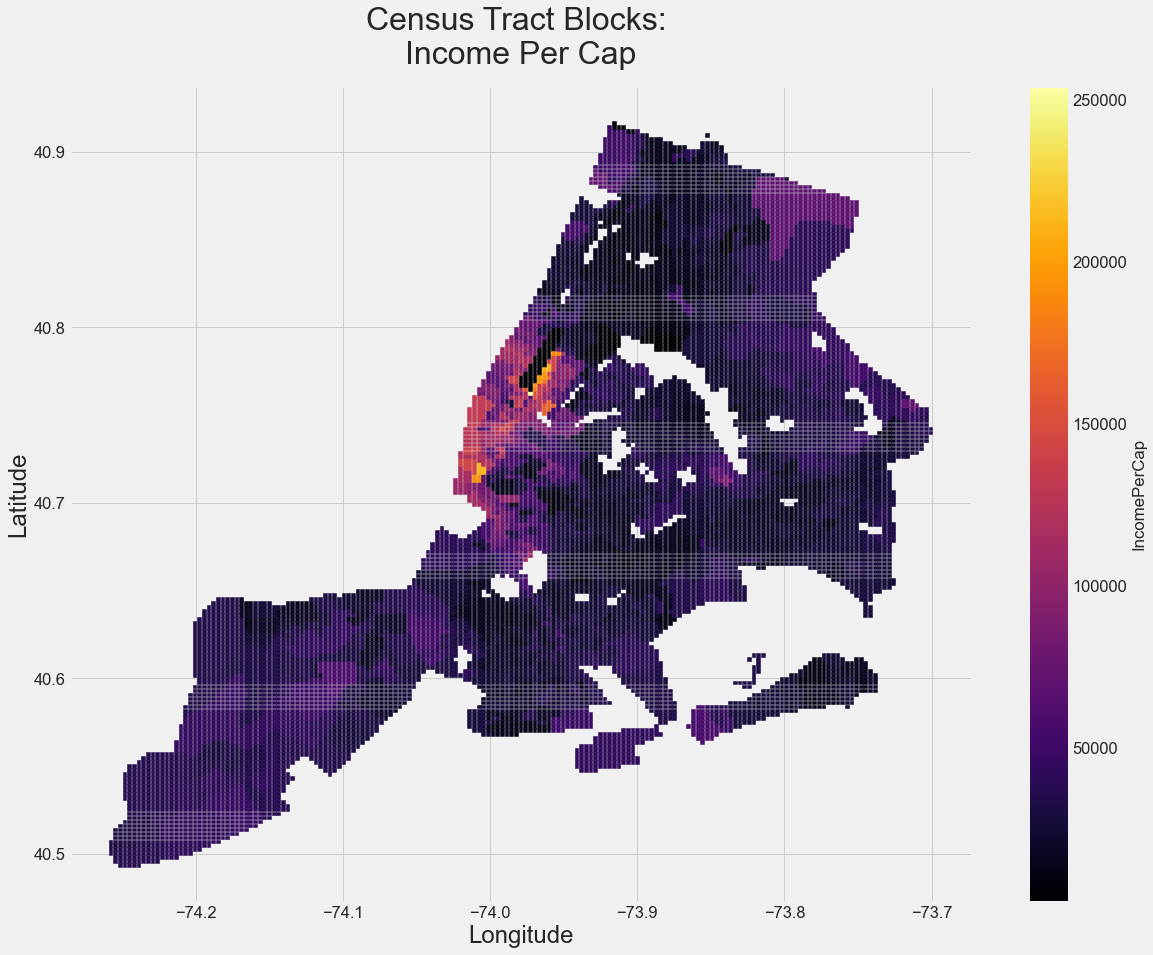

In [9]:
census_block_map('IncomePerCap', 'inferno')

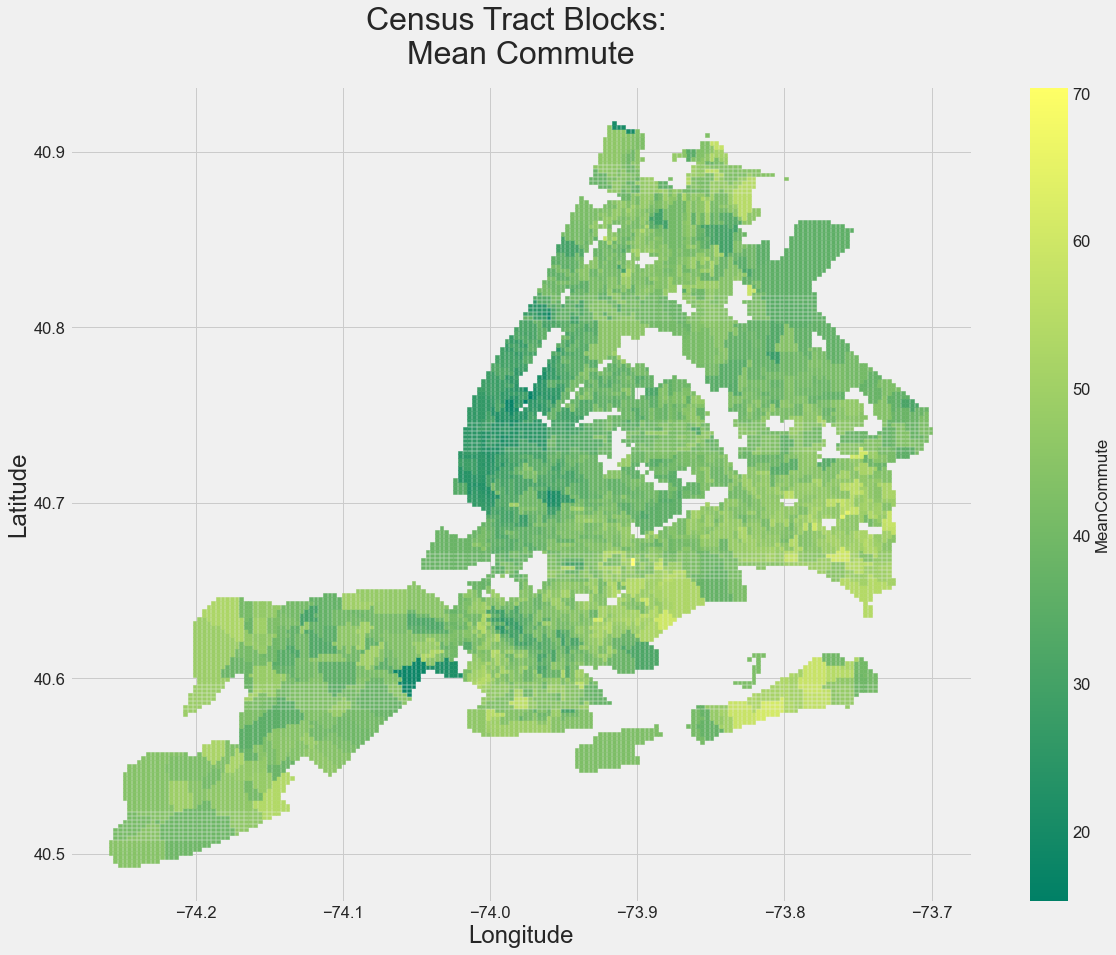

In [10]:
census_block_map('MeanCommute', 'summer')

The commute time has an interesting relationship with Income Per Capita in Manhattan in particular 

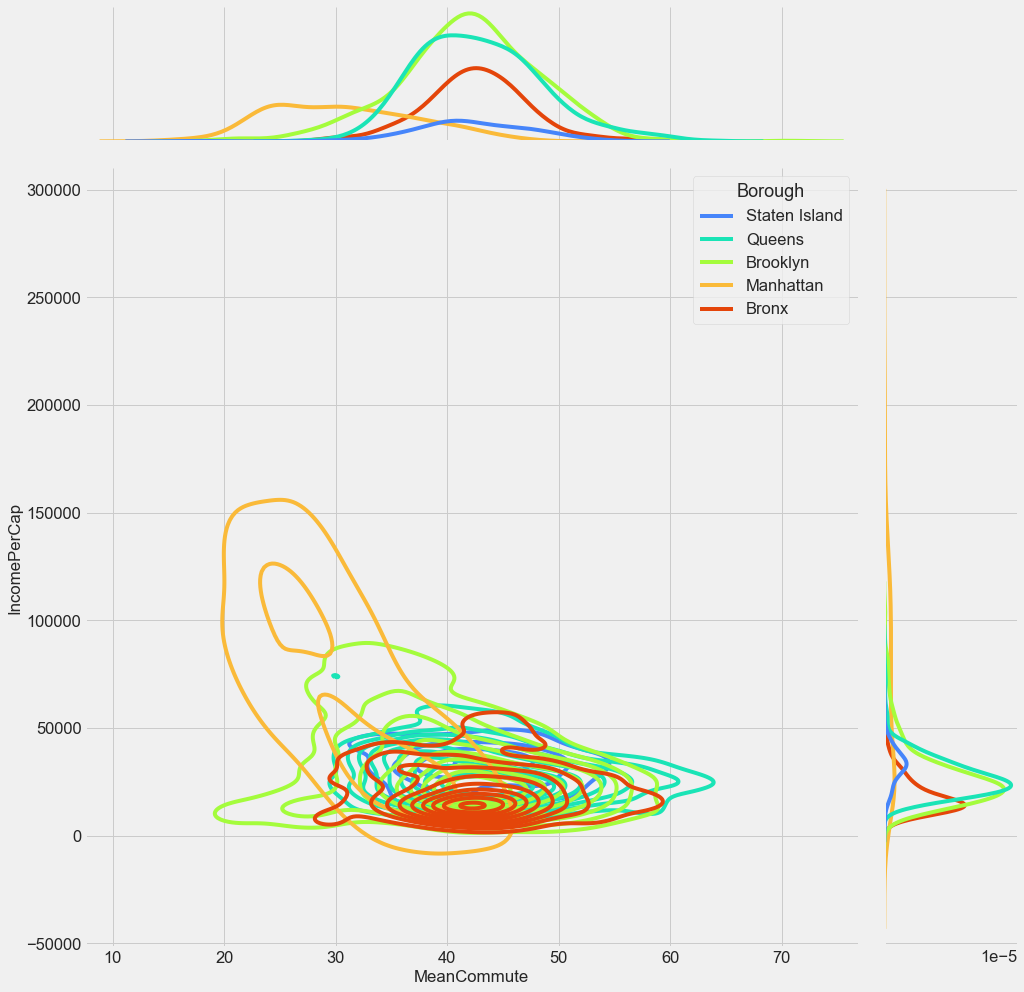

In [11]:
sns.jointplot(data=census, x='MeanCommute', y='IncomePerCap', hue='Borough', 
              kind='kde', palette='turbo', height=14);

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


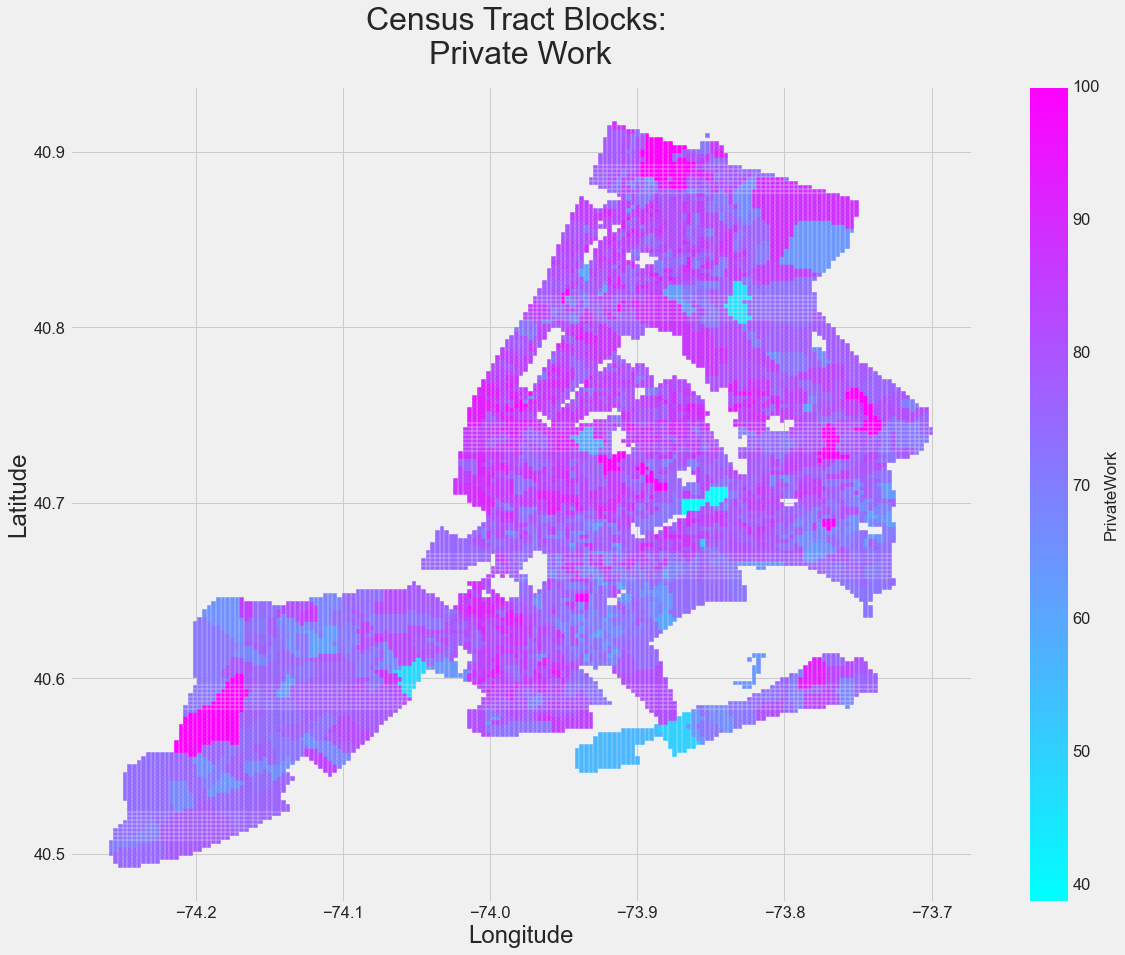

In [12]:
census_block_map('PrivateWork', 'cool')

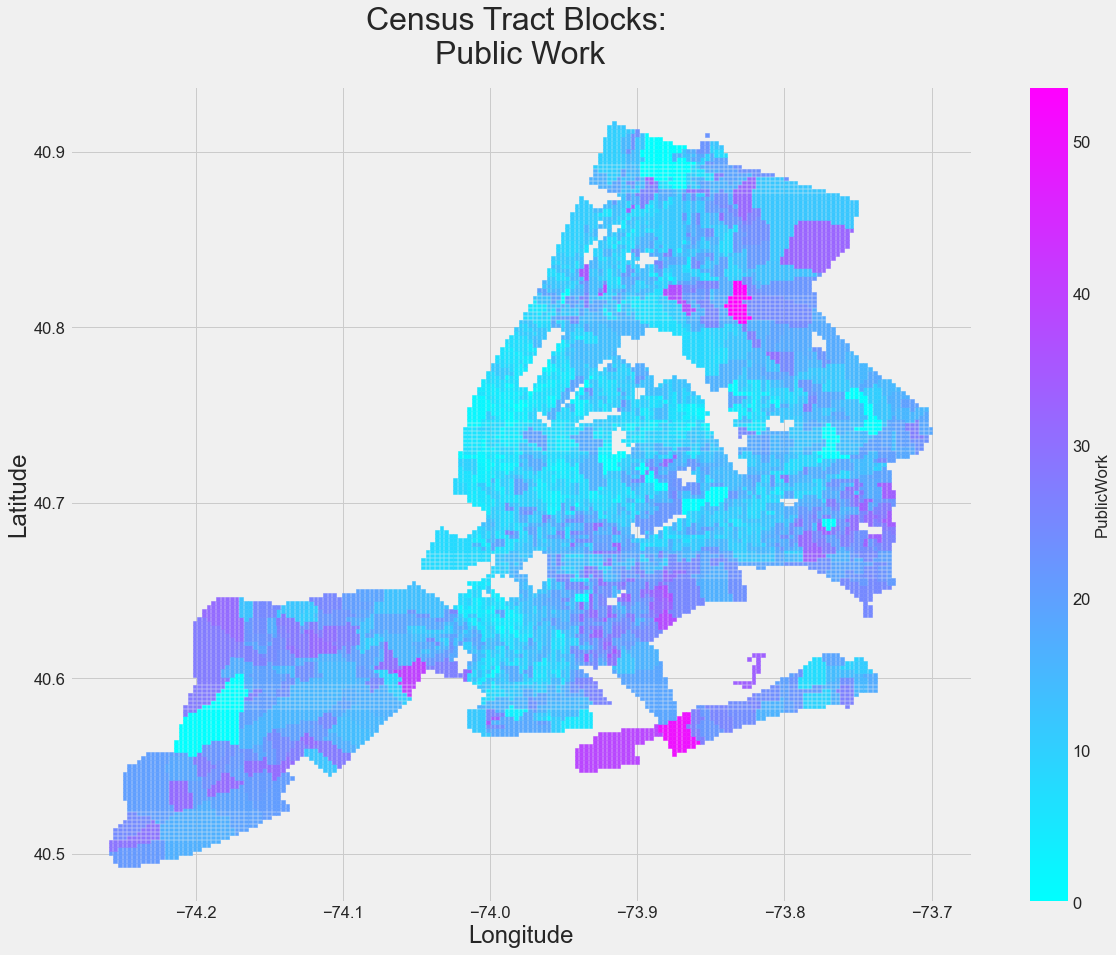

In [13]:
census_block_map('PublicWork', 'cool')

The difference between Professional and Service workers is also one of the most notable differences between the boroughs 

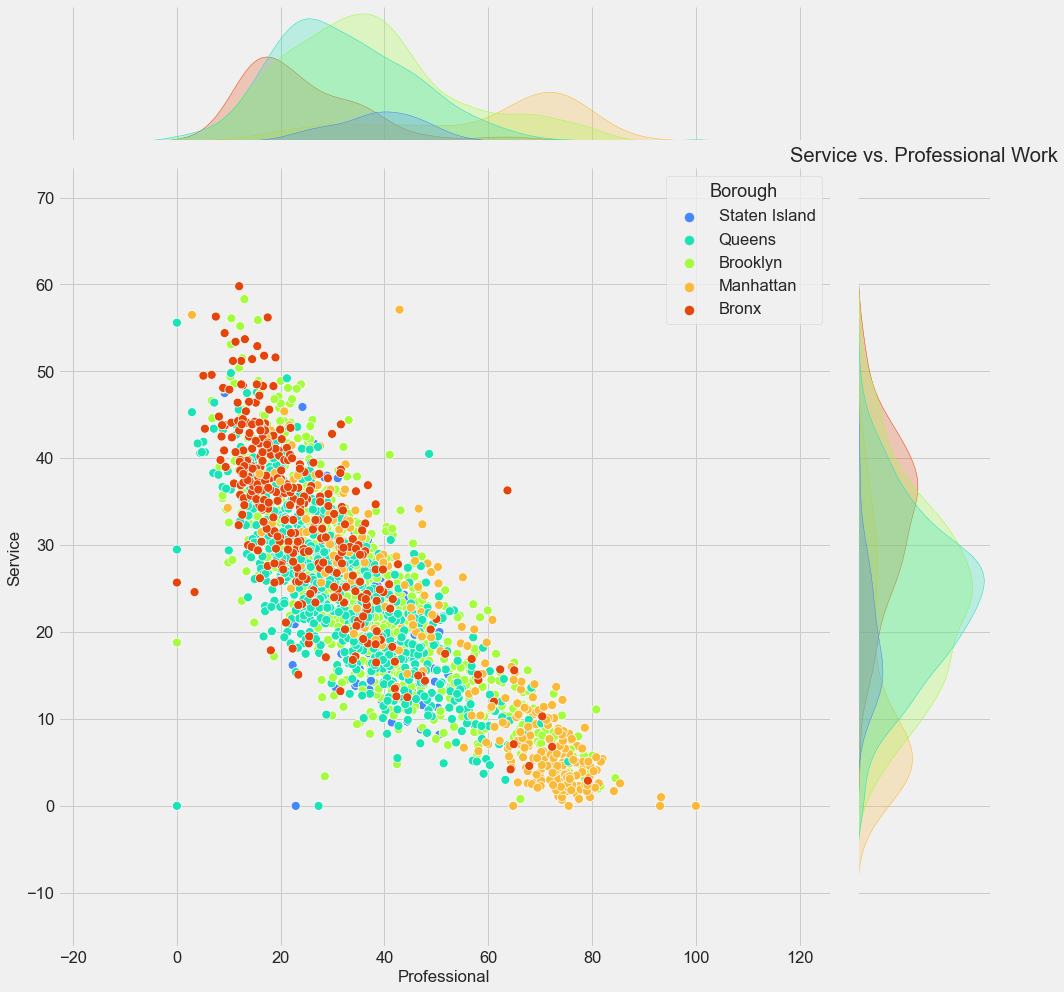

In [20]:
sns.jointplot(data=census, x='Professional', y='Service', 
              hue='Borough', 
              kind='scatter', palette='turbo', height=14)


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


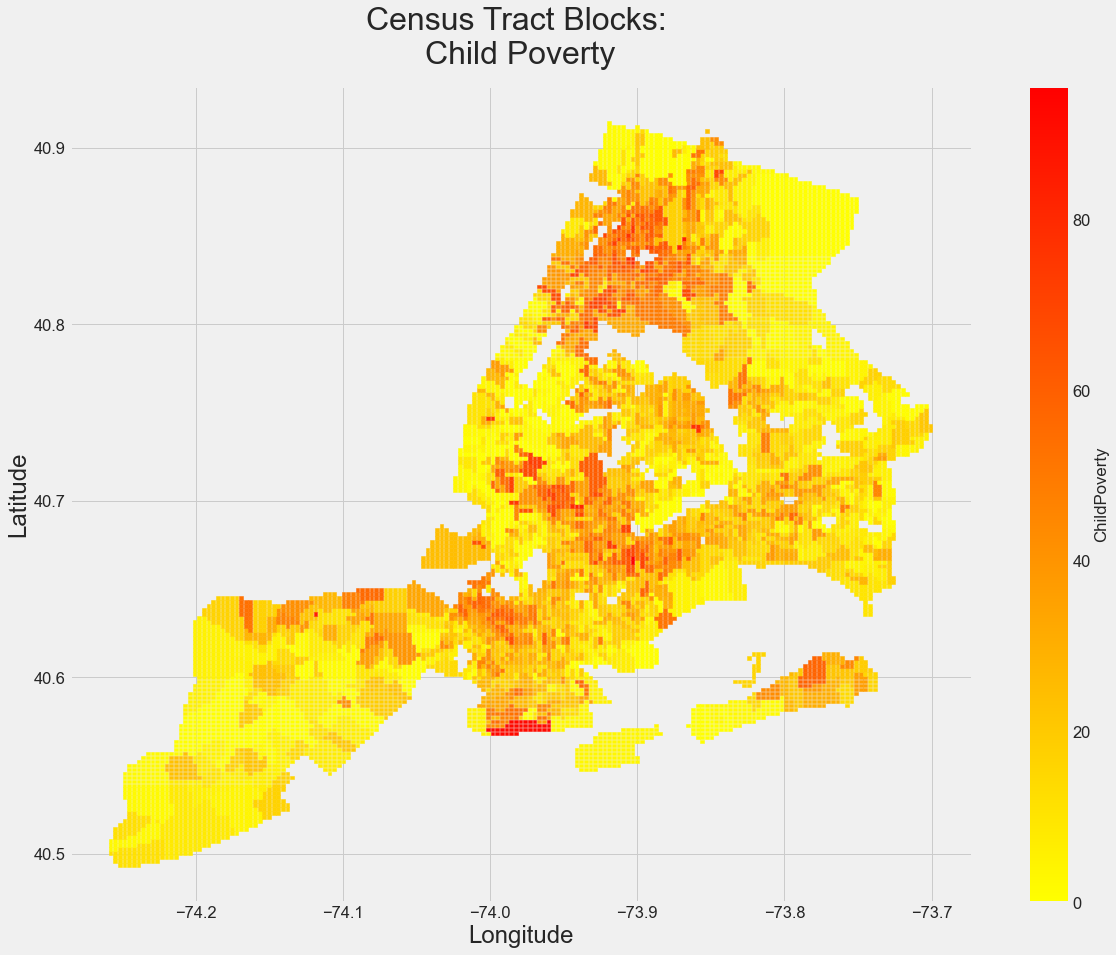

In [15]:
census_block_map('ChildPoverty', 'autumn_r')

---

#### Race Demographics

In [27]:
total = 0
for i in ['White', 'Hispanic', 'Black', 'Asian']:
    perc = sum(census[i] * census.TotalPop)/ sum(census.TotalPop)
    total += perc
    print(f"Pop Percent {i}:", perc)
print()
print("Total:", total)

Pop Percent White: 32.5220006987062
Pop Percent Hispanic: 28.867831479327133
Pop Percent Black: 22.38244039424027
Pop Percent Asian: 13.44962373824992

Total: 97.22189631052353


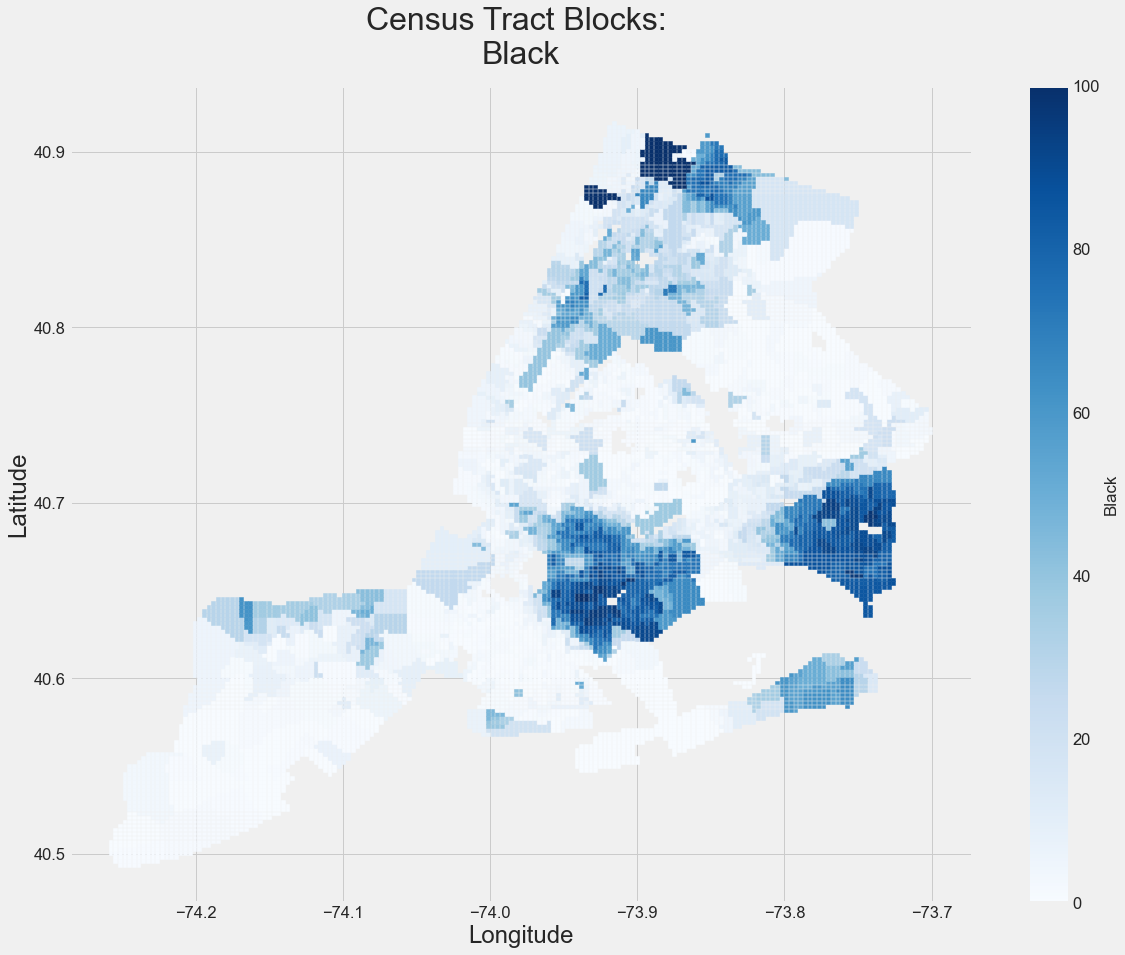

In [16]:
census_block_map('Black', 'Blues')

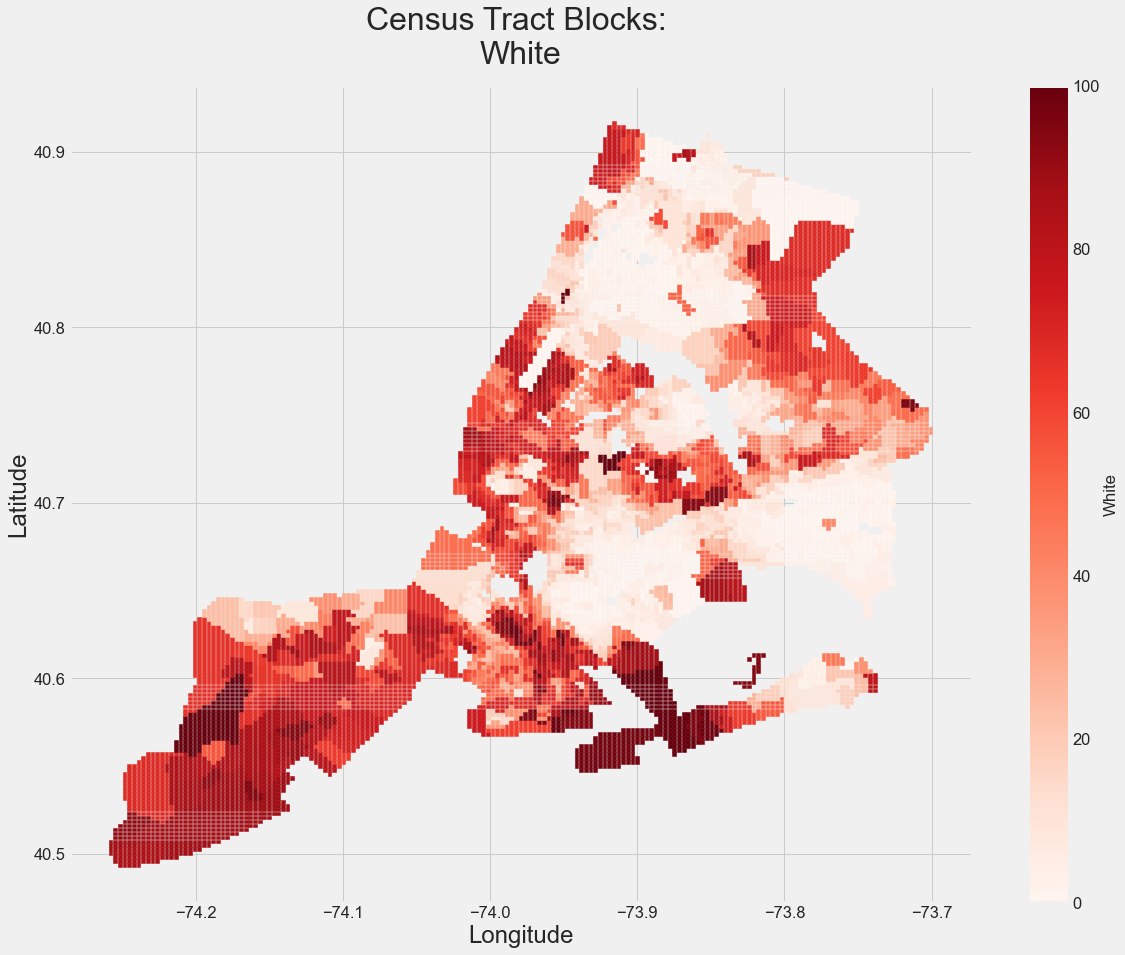

In [17]:
census_block_map('White', 'Reds')

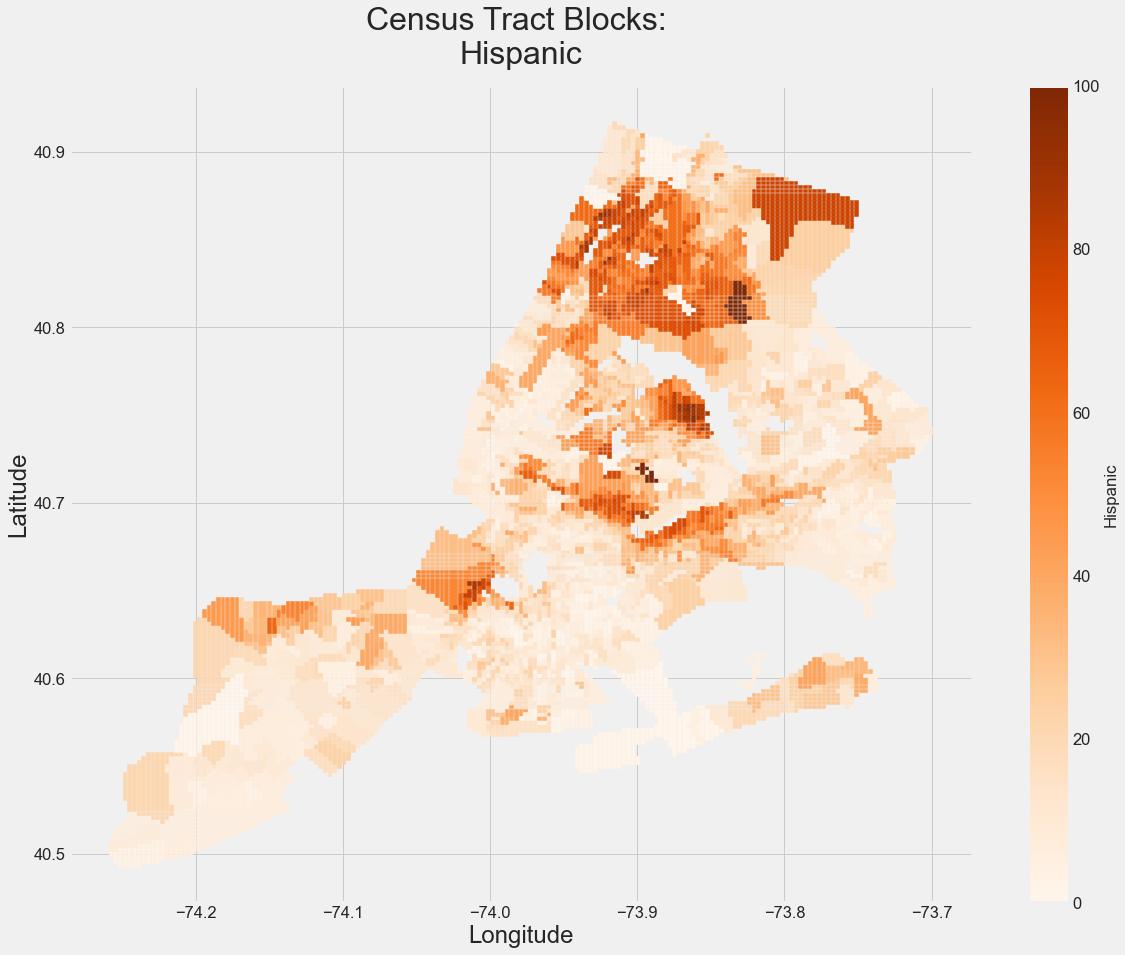

In [18]:
census_block_map('Hispanic', 'Oranges')

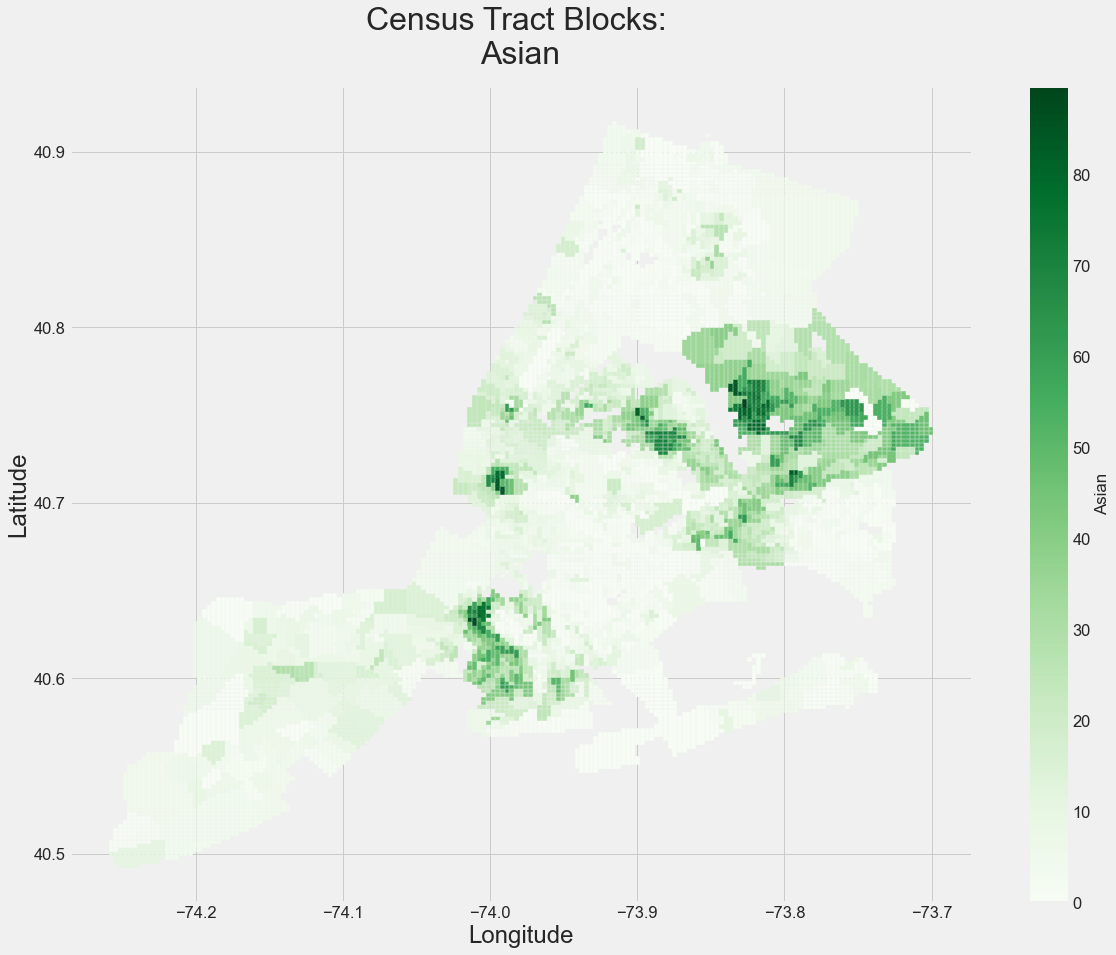

In [19]:
census_block_map('Asian', 'Greens')

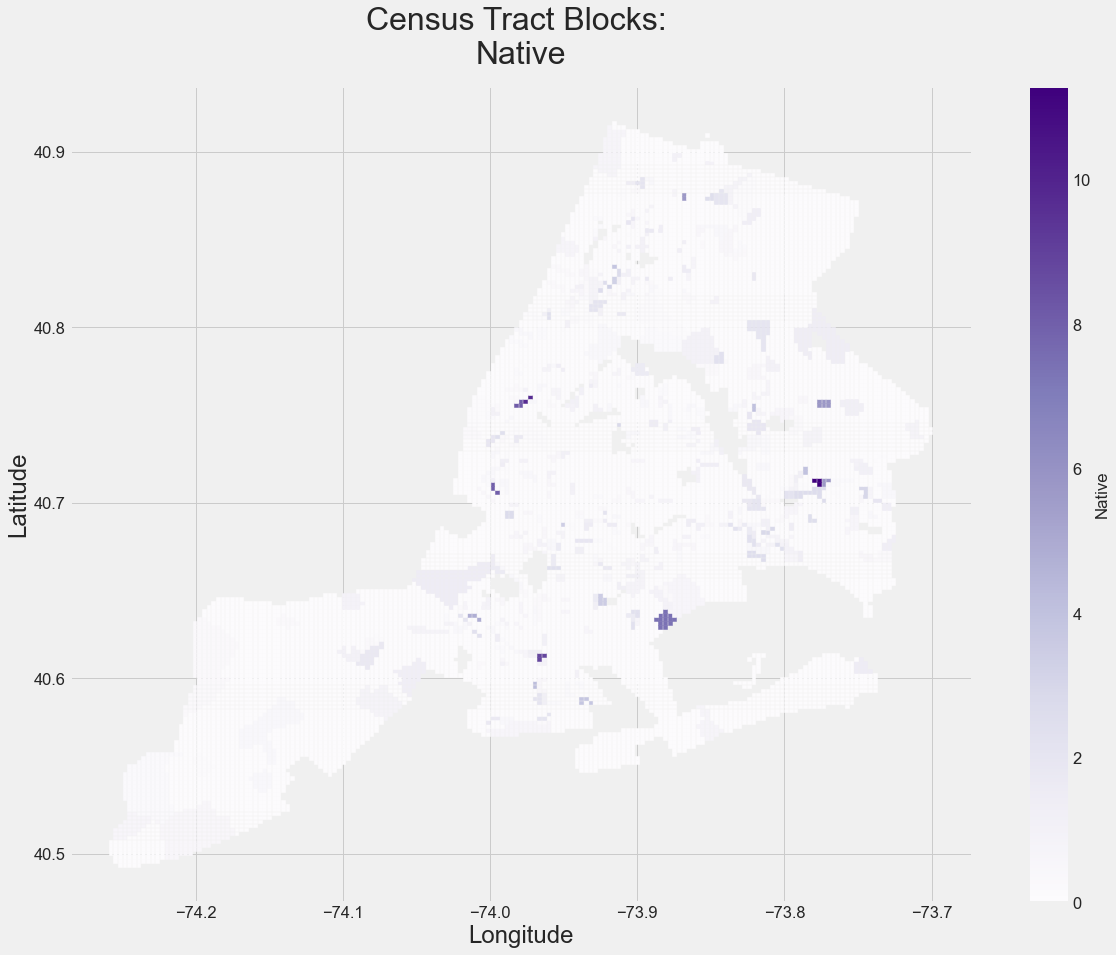

In [187]:
census_block_map('Native', 'Purples')

How few indigenous people living in a place with an island called 'Manhattan'

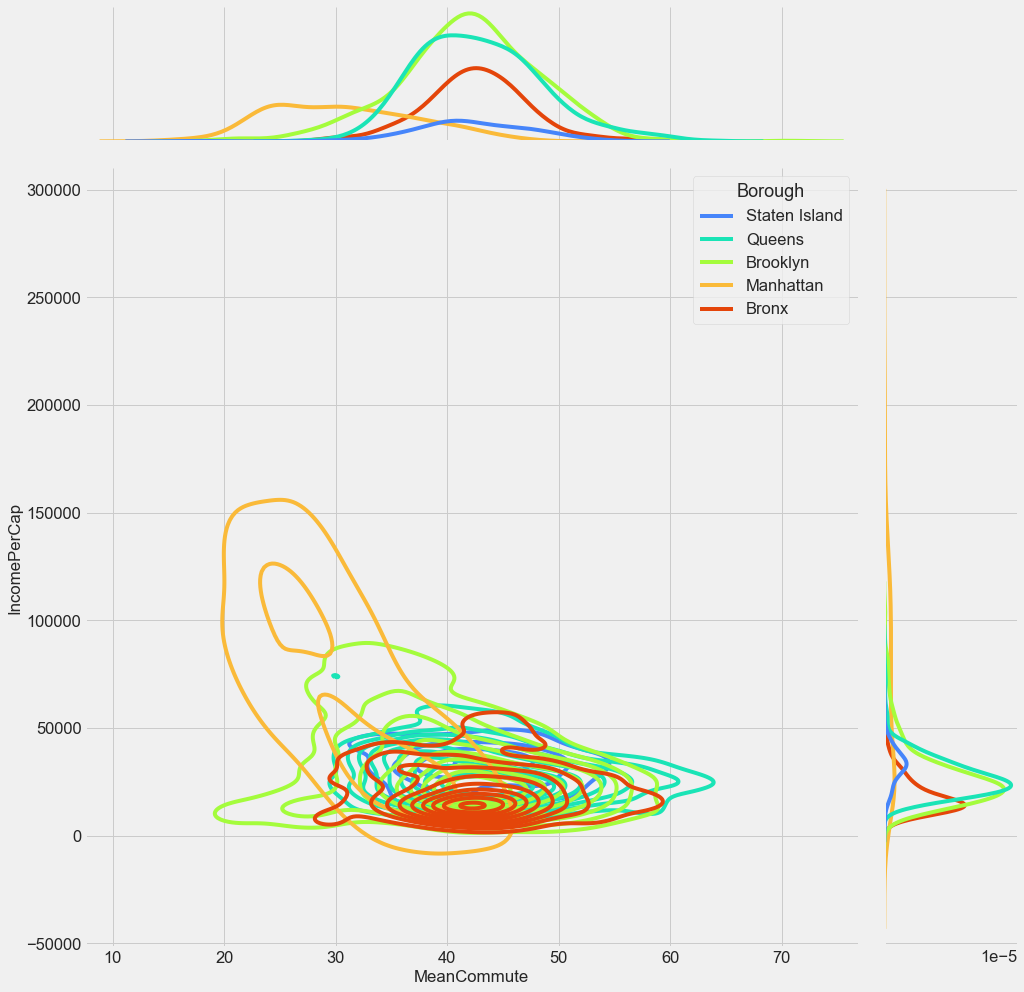

In [208]:
# sns.jointplot(data=census, x='Professional', y='Service', 
# #               hue='Borough', 
#               kind='reg', palette='turbo', height=14);

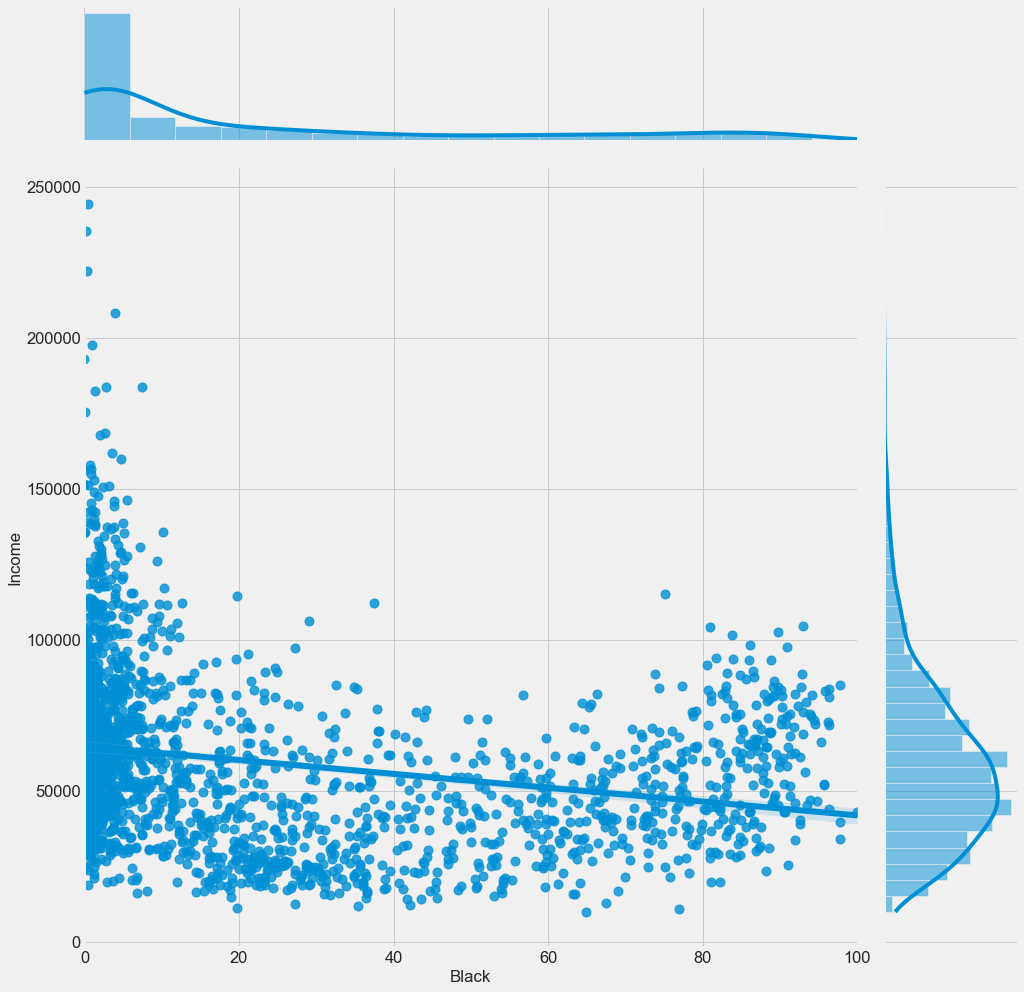

In [215]:
sns.jointplot(data=census, x='Black', y='Income', 
#               hue='Borough', 
              kind='reg', palette='turbo', height=14);

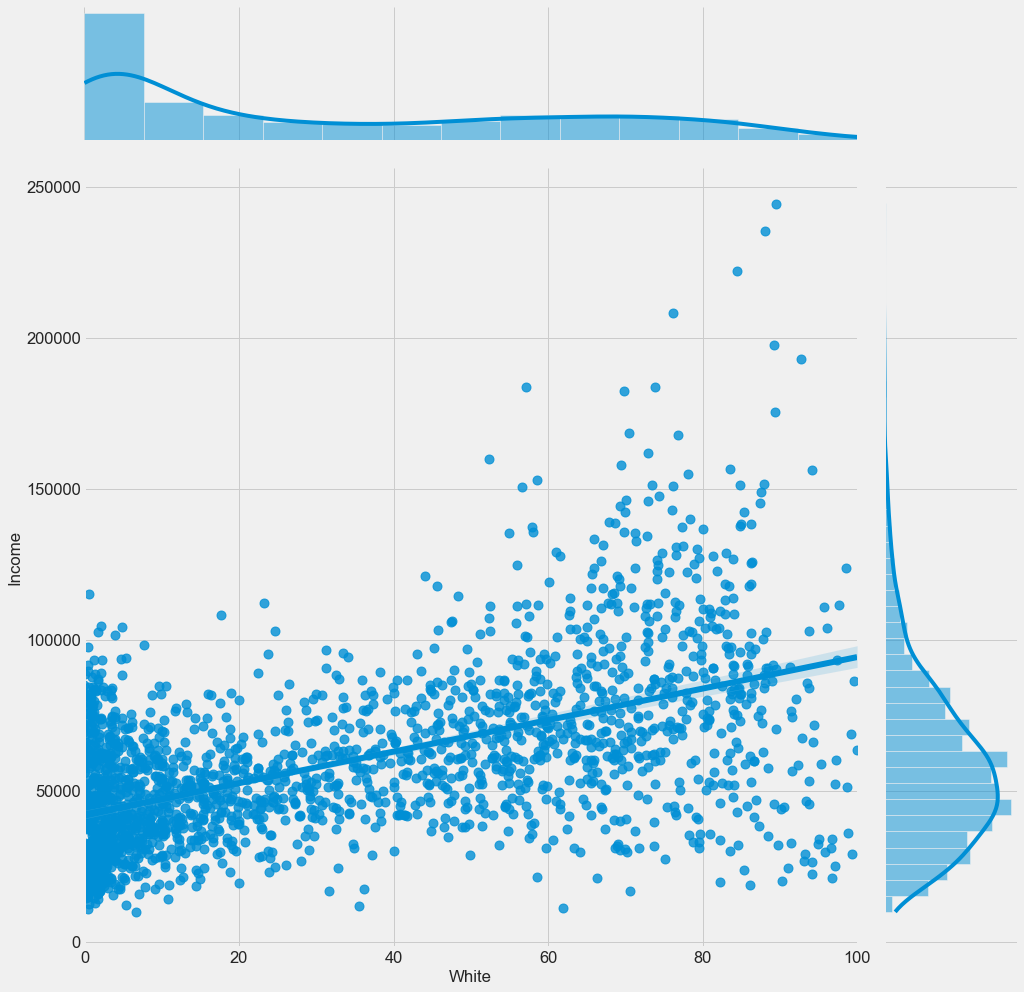

In [214]:
sns.jointplot(data=census, x='White', y='Income', 
#               hue='Borough', 
              kind='reg', palette='turbo', height=14);